# <b>02_train_model.ipynb</b>
https://github.com/Kazuhito00/Single-Hand-Localization<br>
ハードウェア アクセラレータ：GPU

# Google Colaboratory：GPU残時間確認

In [1]:
!cat /proc/uptime | awk '{print 0.5 - ($1 /60 /60 /24)"days (" 12 - ($1 / 60 / 60) "h)"}'

0.499274days (11.9826h)


In [2]:
!nvidia-smi

Mon Mar 29 13:21:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Google Colaboratory：Google Driveマウント

In [3]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


# データセットダウンロード

In [4]:
!git clone https://github.com/Kazuhito00/Single-Hand-Localization

Cloning into 'Single-Hand-Localization'...
remote: Enumerating objects: 1439, done.
remote: Counting objects: 100% (1439/1439), done.
remote: Compressing objects: 100% (1436/1436), done.
remote: Total 62506 (delta 3), reused 1437 (delta 3), pack-reused 61067
Receiving objects: 100% (62506/62506), 5.03 GiB | 28.63 MiB/s, done.
Resolving deltas: 100% (266/266), done.
Checking out files: 100% (65426/65426), done.


# データセット読み込み

In [5]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf

def random_seed_initialize(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

RANDOM_SEED = 42
random_seed_initialize(RANDOM_SEED)

In [6]:
dataset_directory_path = '/content/Single-Hand-Localization/01_dataset'
dataset_csv_path = dataset_directory_path + '/dataset.csv'

In [7]:
 dataset_table = pd.read_csv(dataset_csv_path, names=('file', 'id', 'x', 'y'))

In [8]:
print(dataset_table)

                              file  id         x         y
0      01_dataset/image/000001.jpg   1  0.796875  0.807407
1      01_dataset/image/000002.jpg   1  0.794792  0.792593
2      01_dataset/image/000003.jpg   1  0.794792  0.792593
3      01_dataset/image/000004.jpg   1  0.794792  0.794444
4      01_dataset/image/000005.jpg   1  0.794792  0.794444
...                            ...  ..       ...       ...
65400  01_dataset/image/065401.jpg   2  0.450000  0.395833
65401  01_dataset/image/065402.jpg   2  0.456250  0.400000
65402  01_dataset/image/065403.jpg   2  0.468750  0.395833
65403  01_dataset/image/065404.jpg   2  0.487500  0.400000
65404  01_dataset/image/065405.jpg   0  0.000000  0.000000

[65405 rows x 4 columns]


In [9]:
dataset_table['file'] = '/content/Single-Hand-Localization/' + dataset_table['file']

In [10]:
print(dataset_table['file'].iloc[0])

/content/Single-Hand-Localization/01_dataset/image/000001.jpg


# テストデータ分割

In [11]:
TRAIN_RATIO = 0.75

IMAGE_WIDTH = 128 # 224
IMAGE_HEIGHT = 128 # 224

NUM_CLASSES = 3

In [12]:
random_permutation = np.random.permutation(len(dataset_table))
train_test_split_index = int(len(dataset_table) * TRAIN_RATIO)
train_indexes = random_permutation[:train_test_split_index]
validation_indexes = random_permutation[train_test_split_index:]

# データジェネレーター作成

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [14]:
# Albumentationsを用いたデータ拡張設定
import albumentations as album

def preprocessing_augmentation_function(param_p = 0.0):
    transform = [
        album.Blur(blur_limit=15, p=param_p),
        album.RandomGamma(gamma_limit=(50, 150), p=param_p),
        album.OpticalDistortion(distort_limit=1, shift_limit=0.05, interpolation=1, border_mode=4, p=param_p),
        album.GridDistortion(num_steps=6, distort_limit=0.5, interpolation=1, border_mode=4, p=param_p),
        album.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=30, val_shift_limit=30, p=param_p),
        album.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=param_p),
        album.MotionBlur(blur_limit=15, p=param_p),
        album.GaussNoise(var_limit=(10.0, 100.0), mean=0, p=param_p),
        album.GlassBlur(sigma=0.7, max_delta=4, iterations=2, p=param_p),
        album.ChannelShuffle(p=param_p),
        album.ToGray(p=param_p),
        album.ToSepia(p=param_p),
        album.ImageCompression(quality_lower=0, quality_upper=30, p=param_p),
        album.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, brightness_by_max=True, p=param_p),
        album.RandomFog(fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.08, p=param_p),
        album.Solarize(threshold=200, p=param_p),
        album.MultiplicativeNoise(multiplier=(0.7, 1.3), per_channel=False, elementwise=False, p=param_p),
        album.CoarseDropout(max_holes=16, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=255, p=param_p),
        album.CoarseDropout(max_holes=16, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=0, p=param_p),
    ]
    augmentation_function = album.Compose(transform)

    def augmentation(x):
        augmentation_image = augmentation_function(image=x)
        return augmentation_image['image']

    return augmentation

In [15]:
from PIL import Image

def get_data_generator(dataframe, indexes, for_training, batch_size=32, preprocessing_function=None):
    image_list, id_list, point_list = [], [], []
    while True:
        for index in indexes:
            data = dataframe.iloc[index]
            file, id, x, y = data['file'], data['id'], data['x'], data['y']

            image = Image.open(file)
            image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
            if preprocessing_function is not None:
                image = preprocessing_function(np.array(image))
                image = image / 255.0
            else:
                image = np.array(image) / 255.0
            image_list.append(image)

            id_list.append(tf.keras.utils.to_categorical(id, NUM_CLASSES))

            point_list.append(np.array([x, y], dtype=np.float32))

            if len(image_list) >= batch_size:
                yield np.array(image_list), [np.array(point_list), np.array(id_list)]
                image_list, id_list, point_list = [], [], []
        if not for_training:
            break

# モデル構築

In [16]:
import tensorflow as tf

In [17]:
if True:
    base_model = tf.keras.applications.MobileNet(
        include_top=False, 
        alpha = 1.0, # Width Multiplier
        weights='imagenet', 
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    )
if False:
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False, 
        alpha = 1.0, # Width Multiplier
        weights='imagenet', 
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    )
if False:
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    )

17227776/17225924 [==============================] - 0s 0us/step


In [18]:
# 重みを固定しない
base_model.trainable = True

In [19]:
# localization_output = tf.keras.layers.Dense(512, activation='relu')(base_model.output)
# localization_output = tf.keras.layers.Dense(256, activation='relu')(localization_output)
# localization_output = tf.keras.layers.Flatten()(localization_output)
# localization_output = tf.keras.layers.Dense(units=2, name='localization_output')(localization_output)
localization_output = tf.keras.layers.Flatten()(base_model.output)
localization_output = tf.keras.layers.Dense(units=2, name='localization_output')(localization_output)

class_output = tf.keras.layers.Flatten()(base_model.output)
class_output = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='class_output')(class_output)

model = tf.keras.Model(inputs=base_model.inputs, outputs=[localization_output, class_output])

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
    loss={'localization_output': 'mae', 'class_output': 'categorical_crossentropy'},
    metrics={'localization_output': 'mae', 'class_output': 'accuracy'}
)

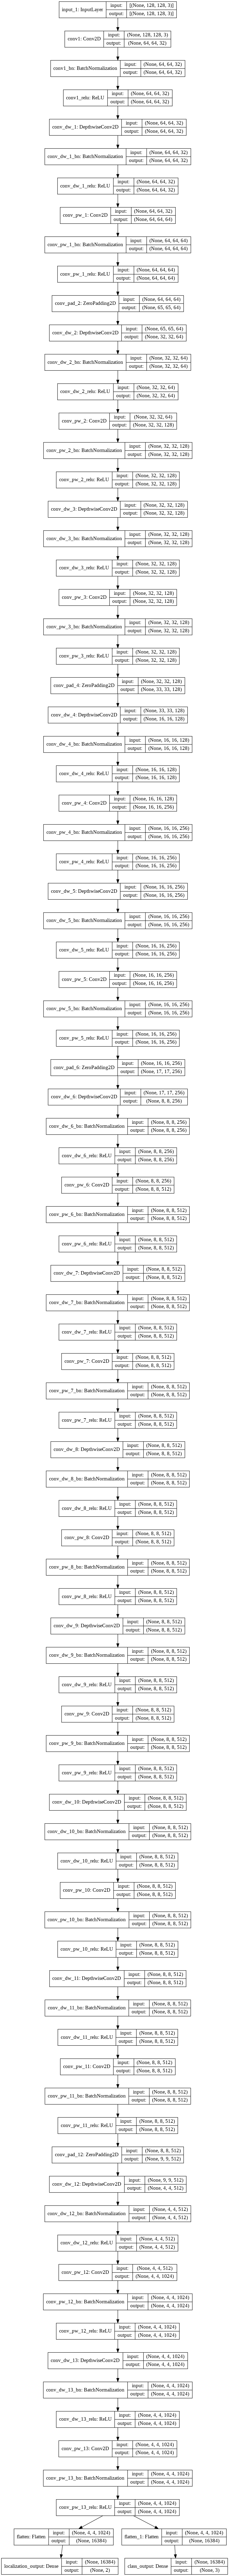

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 64, 64, 32)   0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [23]:
# データジェネレーター生成
batch_size = 256 # 128

train_data_generator = get_data_generator(
    dataset_table, 
    train_indexes, 
    for_training=True, 
    batch_size=batch_size,
    preprocessing_function = preprocessing_augmentation_function(0.3)
)
validation_data_generator = get_data_generator(
    dataset_table, 
    validation_indexes, 
    for_training=True, 
    batch_size=batch_size
)

In [24]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    './model_checkpoint', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)

# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1) 

# 学習率低減コールバック
# def lr_scheduler(epoch, lr):
#     x = lr * (0.9 ** (epoch // 10))
#     return x
# lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
lrp_callback =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8)

In [25]:
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(train_indexes) // batch_size,
    epochs=100,
    validation_data=validation_data_generator,
    validation_steps=len(validation_indexes) // batch_size,
    # callbacks=[cp_callback, es_callback, lr_callback]
    callbacks=[cp_callback, es_callback, lrp_callback]
)

Epoch 1/100
191/191 [==============================] - 856s 4s/step - loss: 3.0476 - localization_output_loss: 1.4035 - class_output_loss: 1.6442 - localization_output_mae: 1.4035 - class_output_accuracy: 0.5449 - val_loss: 0.6800 - val_localization_output_loss: 0.5495 - val_class_output_loss: 0.1306 - val_localization_output_mae: 0.5495 - val_class_output_accuracy: 0.9474

Epoch 00001: val_loss improved from inf to 0.68001, saving model to ./model_checkpoint
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 2/100
191/191 [==============================] - 822s 4s/step - loss: 0.7161 - localization_output_loss: 0.1878 - class_output_loss: 0.5283 - localization_output_mae: 0.1878 - class_output_accuracy: 0.7570 - val_loss: 0.2608 - val_localization_output_loss: 0.1724 - val_class_output_loss: 0.0884 - val_localization_output_mae: 0.1724 - val_class_output_accuracy: 0.9709

Epoch 00002: val_loss improved from 0.68001 to 0.26082, saving model to ./model_checkpoint
INFO:te

# グラフ表示

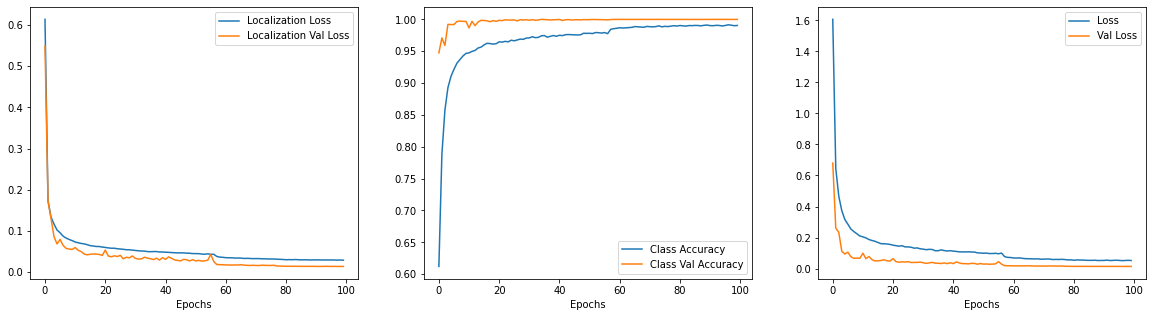

In [26]:
import matplotlib.pyplot as plt

def plot_train_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].plot(history.history['localization_output_loss'], label='Localization Loss')
    axes[0].plot(history.history['val_localization_output_loss'], label='Localization Val Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['class_output_accuracy'], label='Class Accuracy')
    axes[1].plot(history.history['val_class_output_accuracy'], label='Class Val Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['loss'], label='Loss')
    axes[2].plot(history.history['val_loss'], label='Val Loss')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

plot_train_history(history)

# HDF5ファイル保存

In [27]:
model = tf.keras.models.load_model('./model_checkpoint')

In [28]:
# 推論専用モデルとして保存
hdf_filename = 'SingleHandLocalization.hdf5'
model.save(hdf_filename, include_optimizer=False)

In [29]:
!cp 'SingleHandLocalization.hdf5' '/content/gdrive/MyDrive'

# TensorFlow推論テスト

In [30]:
# 保存したモデルのロード
loaded_model = tf.keras.models.load_model(hdf_filename)

In [31]:
test_index = validation_indexes[0]
print(dataset_table['file'].iloc[test_index])
print(dataset_table['id'].iloc[test_index])
print(dataset_table['x'].iloc[test_index])
print(dataset_table['y'].iloc[test_index])

/content/Single-Hand-Localization/01_dataset/image/017334.jpg
2
0.34895833299999995
0.25


In [32]:
from PIL import Image

test_image = Image.open(dataset_table['file'].iloc[test_index])
test_image = np.array(test_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT)))
test_image = test_image.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
test_image = test_image.astype('float32')
test_image /= 255

In [33]:
predict_result = loaded_model.predict(test_image)

In [34]:
print(np.squeeze(predict_result[0]))
print(np.squeeze(predict_result[1]), np.argmax(np.squeeze(predict_result[1])))

[0.37587476 0.23336953]
[2.9837967e-08 3.0460598e-09 1.0000000e+00] 2


In [35]:
%%timeit -n 100
loaded_model.predict(test_image)

100 loops, best of 5: 31.6 ms per loop


# Tensorflow-Lite用のモデルへ変換

In [36]:
tflite_save_path = './SingleHandLocalization.tflite'

In [37]:
# モデルを変換(量子化)
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp1rtqba22/assets


3550224

In [38]:
!cp 'SingleHandLocalization.tflite' '/content/gdrive/MyDrive'

# Tensorflow-Liteモデル推論テスト

In [39]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [40]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'input_1', 'index': 0, 'shape': array([  1, 128, 128,   3], dtype=int32), 'shape_signature': array([ -1, 128, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 94, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'Identity_1', 'index': 95, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_di

In [41]:
interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
tflite_result0 = interpreter.get_tensor(output_details[0]['index'])
tflite_result1 = interpreter.get_tensor(output_details[1]['index'])

print(np.squeeze(tflite_result0))
print(np.argmax(np.squeeze(tflite_result0)))
print(np.squeeze(tflite_result1))

[3.0177830e-08 3.1705198e-09 1.0000000e+00]
2
[0.36945733 0.2379115 ]


In [42]:
%%timeit -n 100
interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
tflite_result0 = interpreter.get_tensor(output_details[0]['index'])
tflite_result1 = interpreter.get_tensor(output_details[1]['index'])

100 loops, best of 5: 468 ms per loop


# ONNXへ変換

In [43]:
loaded_model.save('saved_model_for_onnx', save_format='tf')

INFO:tensorflow:Assets written to: saved_model_for_onnx/assets


INFO:tensorflow:Assets written to: saved_model_for_onnx/assets


In [44]:
!pip install onnxruntime
!pip install tf2onnx

     |████████████████████████████████| 4.1MB 16.3MB/s 
     |████████████████████████████████| 348kB 10.7MB/s 
     |████████████████████████████████| 14.5MB 409kB/s 


In [45]:
!python -m tf2onnx.convert --saved-model='saved_model_for_onnx' \
                           --opset=9 \
                           --output='SingleHandLocalization.onnx'

2021-03-30 12:01:35.350458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-03-30 12:01:39.602851: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-30 12:01:39.612989: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-30 12:01:39.642211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-30 12:01:39.642645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 


In [46]:
!cp 'SingleHandLocalization.onnx' '/content/gdrive/MyDrive'

# ONNXモデル推論テスト

In [47]:
import onnxruntime
onnx_session = onnxruntime.InferenceSession('SingleHandLocalization.onnx')

In [48]:
input_name = onnx_session.get_inputs()[0].name
output_localization = onnx_session.get_outputs()[0].name
output_class = onnx_session.get_outputs()[1].name

In [49]:
onnx_result = onnx_session.run([output_localization, output_class], {input_name: test_image})

In [50]:
print(np.squeeze(onnx_result[0]))
print(np.squeeze(onnx_result[1]))

[2.9837800e-08 3.0460308e-09 1.0000000e+00]
[0.37587523 0.23336983]


In [51]:
%%timeit -n 100
onnx_result = onnx_session.run([output_localization, output_class], {input_name: test_image})

100 loops, best of 5: 5.58 ms per loop
